In [13]:
import numpy as np
import pandas as pd
import yaml
import torch
from copy import deepcopy
from tqdm import tqdm
import matplotlib.pyplot as plt
from celldreamer.eval.eval_utils import normalize_and_compute_metrics
import scipy.sparse as sp
import time

from torch import nn
import scanpy as sc    

from celldreamer.data.scrnaseq_loader import RNAseqLoader
from celldreamer.models.featurizers.category_featurizer import CategoricalFeaturizer
from celldreamer.models.fm.fm import FM
from celldreamer.eval.optimal_transport import wasserstein
import random
from celldreamer.models.base.encoder_model import EncoderModel
from celldreamer.models.base.utils import unsqueeze_right

from celldreamer.paths import DATA_DIR

device  = "cuda" if torch.cuda.is_available() else "cpu"

sc.settings.figdir = 'figures'  # Directory to save figures
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(6, 6)) 

## Step 1: Initialize data

In [2]:
dataset_config = {'dataset_path': DATA_DIR / 'processed' / 'atac' / 'pbmc' / 'pbmc10k_rna_multiome_test.h5ad',
                    'layer_key': 'X_counts',
                    'covariate_keys': ['cell_type'],
                    'conditioning_covariate': 'cell_type',
                    'subsample_frac': 1,
                    'encoder_type': 'learnt_autoencoder',
                    'target_max': 1,
                    'target_min': -1,
                    'one_hot_encode_features': False,
                    'split_rates': [0.90, 0.10],
                    'cov_embedding_dimensions': 256}

data_path = dataset_config["dataset_path"]

dataset = RNAseqLoader(data_path=data_path,
                                layer_key=dataset_config["layer_key"],
                                covariate_keys=dataset_config["covariate_keys"],
                                subsample_frac=dataset_config["subsample_frac"], 
                                encoder_type=dataset_config["encoder_type"])

in_dim = dataset.X.shape[1]
size_factor_statistics = {"mean": dataset.log_size_factor_mu, 
                                  "sd": dataset.log_size_factor_sd}
n_cat = len(dataset.id2cov["cell_type"])

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


## Step 2: Initialize encoder

In [3]:
encoder_config = {
    "x0_from_x_kwargs": {
        "dims": [512, 256, 100],
        "batch_norm": True,
        "dropout": False,
        "dropout_p": 0.0
    },
    "learning_rate": 0.001,
    "weight_decay": 0.00001,
    "covariate_specific_theta": False
}

state_dict_path = "/home/icb/alessandro.palma/environment/cfgen/project_folder/experiments/REBUTTALS_PBMC10K/201a2a6e-9dd8-4641-a62b-fc1cdf874724/checkpoints/epoch_39.ckpt"

In [4]:
encoder_model = EncoderModel(in_dim=in_dim,
                              n_cat=n_cat,
                              conditioning_covariate=dataset_config["conditioning_covariate"], 
                              encoder_type=dataset_config["encoder_type"],
                              **encoder_config)
encoder_model.eval()

encoder_model.load_state_dict(torch.load(state_dict_path)["state_dict"])

<All keys matched successfully>

## Step 3: Initialize FM model

In [5]:
generative_model_config = {'learning_rate': 0.0001,
                            'weight_decay': 0.00001,
                            'antithetic_time_sampling': True,
                            'sigma': 0.0001}

In [6]:
ckpt = torch.load("/home/icb/alessandro.palma/environment/cfgen/project_folder/experiments/REBUTTALS_PBMC10K_FM/65501646-66de-44e9-a3ca-bb00e9093777/checkpoints/epoch_1999.ckpt")

denoising_model = ckpt["hyper_parameters"]["denoising_model"]
denoising_model.multimodal = False

In [7]:
print(ckpt["hyper_parameters"]["feature_embeddings"]["cell_type"].embeddings.weight)
feature_embeddings = ckpt["hyper_parameters"]["feature_embeddings"]

Parameter containing:
tensor([[ 1.7880e+00, -2.8397e-01,  3.9826e-01,  1.7119e-01,  7.5272e-01,
         -1.7251e+00, -1.0895e+00, -1.5448e+00, -5.6474e-01,  1.1218e-01,
         -7.9413e-01, -1.0884e+00,  5.6892e-02, -5.1691e-01, -4.3587e-01,
         -6.0709e-01,  7.7477e-01, -2.2496e+00,  7.2479e-01, -1.7671e-01],
        [-7.2453e-01, -8.9914e-01,  1.4111e+00, -1.1722e+00,  1.3804e+00,
          2.0335e+00, -2.1916e-01, -1.0073e+00,  1.7943e-01, -7.1224e-01,
         -9.8337e-01, -8.2886e-01, -1.1758e+00, -1.7524e+00,  3.2087e-01,
         -7.5060e-01,  1.0062e+00,  5.5971e-01,  1.0469e+00, -2.7976e-02],
        [ 9.2484e-01, -1.6876e+00,  5.1149e-01, -1.3791e+00, -2.3612e+00,
          2.2362e-01,  2.5512e-01, -8.8583e-01, -1.1055e-01,  8.2535e-01,
          1.3839e+00, -2.9159e-01,  1.3405e+00, -3.8020e-01,  8.8203e-01,
          2.8879e-01,  6.3662e-01,  7.0195e-01, -2.3525e+00, -6.7972e-02],
        [ 1.6783e+00,  1.6932e+00,  9.7796e-01,  7.8068e-01, -1.5265e+00,
          2.0

Initializations

In [8]:
generative_model = FM(
            encoder_model=encoder_model,
            denoising_model=denoising_model,
            feature_embeddings=feature_embeddings,
            plotting_folder=None,
            in_dim=512,
            size_factor_statistics=size_factor_statistics,
            encoder_type=dataset_config["encoder_type"],
            conditioning_covariate=dataset_config["conditioning_covariate"],
            model_type=denoising_model.model_type, 
            **generative_model_config  # model_kwargs should contain the rest of the arguments
            )

generative_model.load_state_dict(ckpt["state_dict"])
generative_model.to("cuda")

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:208: Attribute 'encoder_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder_model'])`.
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:208: Attribute 'denoising_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['denoising_model'])`.


FM(
  (encoder_model): EncoderModel(
    (x0_from_x): MLP(
      (net): Sequential(
        (0): Sequential(
          (0): Linear(in_features=25604, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ELU(alpha=1.0)
        )
        (1): Sequential(
          (0): Linear(in_features=512, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ELU(alpha=1.0)
        )
        (2): Linear(in_features=256, out_features=100, bias=True)
      )
    )
    (x_from_x0): MLP(
      (net): Sequential(
        (0): Sequential(
          (0): Linear(in_features=100, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ELU(alpha=1.0)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
       

# Save three copies of generated datasest 

In [9]:
adata_original = sc.read_h5ad(DATA_DIR / 'processed' / 'atac' / 'pbmc' / 'pbmc10k_rna_multiome_test.h5ad')
adata_original.X = adata_original.layers["X_counts"].copy()
adata_original.obs["size_factor"]=adata_original.X.A.sum(1)
saving_dir = DATA_DIR / "generated" / "pbmc10k_rna"

# Time generation 

In [11]:
times = []

In [14]:
for it in tqdm(range(3)):    
    classes_str =  list(adata_original.obs["cell_type"])
    classes = torch.tensor([dataset.id2cov["cell_type"][c] for  c in classes_str])

    t0 = time.time()
    X_generated = generative_model.sample(batch_size=2000,
                                            n_sample_steps=2, 
                                            covariate="cell_type", 
                                            covariate_indices=classes, 
                                            log_size_factor=None)
    t1 = time.time()
    times.append(t1-t0)
    X_generated = X_generated.to("cpu")

100%|██████████| 3/3 [00:01<00:00,  1.98it/s]


In [15]:
print(np.mean(times))

0.4369134108225505


In [16]:
print(np.std(times)/np.sqrt(3))

0.1489586846332509


In [17]:
joint_adata = sc.AnnData(X=np.concatenate([adata_original.layers["X_counts"].A, X_generated], axis=0), 
                        obs={"dataset_type": ["real" for _ in range(adata_original.shape[0])] + ["generated" for _ in range(X_generated.shape[0])]})

In [18]:
sc.pp.normalize_total(joint_adata, target_sum=1e4)

In [19]:
sc.pp.log1p(joint_adata)

In [20]:
sc.tl.pca(joint_adata)
sc.pp.neighbors(joint_adata)
sc.tl.umap(joint_adata)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


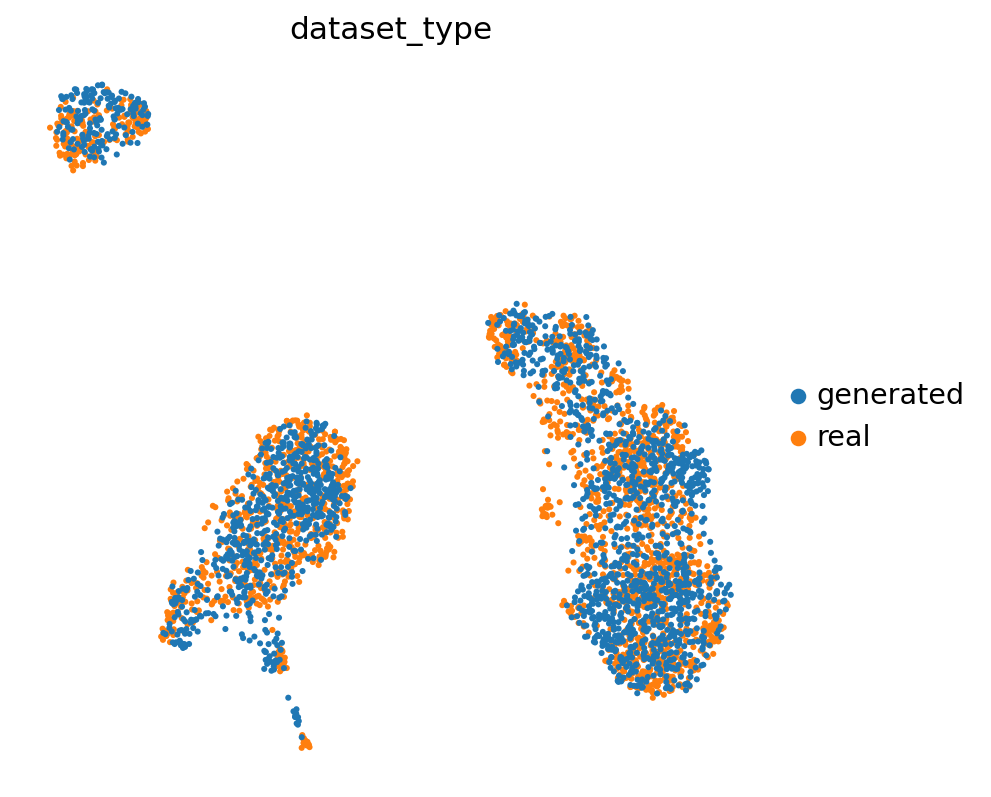

In [21]:
sc.pl.umap(joint_adata, color="dataset_type")